## LLM

In [21]:
import matplotlib.pyplot as plt
from src.tokenizer import TokenizerBPE
from src.data_handling import normalize_to_ascii


import os
import tensorflow as tf
import pickle as pkl
from tqdm.notebook import tqdm
import json

# disable gpu for testing purposes
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [22]:
with open('corpus/coqa-train-v1.0.json', 'r', encoding='utf-8') as f:
    coqa = json.load(f)

data = coqa["data"]
length = len(data)

In [23]:
story_list = []
question_grouped_list = [[] for _ in range(length)]
answer_grouped_list = [[] for _ in range(length)]


for i, sample in tqdm(enumerate(data), total=length):
    story_list.append(sample["story"])
    qa = sample["questions"]
    for question in qa:
        question_grouped_list[i].append(question["input_text"])
    answers = sample["answers"]
    for answer in answers:
        answer_grouped_list[i].append(answer["input_text"])

  0%|          | 0/7199 [00:00<?, ?it/s]

In [24]:
question_flatten_list = [item for sublist in question_grouped_list for item in sublist]
answer_flatten_list = [item for sublist in answer_grouped_list for item in sublist]
corpus = story_list + question_flatten_list + answer_flatten_list

tokenizer = TokenizerBPE(corpus, 8000, lowercase=True)
tokenizer.destroy_hash()
pkl.dump(tokenizer, open("tokenizers/tokenizer_coqa_8k.pkl", "wb"))

Lowercasing corpus


  0%|          | 0/224493 [00:00<?, ?it/s]

[62 50 47 ... 56 62 61]
Merging tokens


  0%|          | 0/8000 [00:00<?, ?it/s]

  t 387718
h e 354940
  a 285930
  w 246927
i n 224782
 t he 196662
  s 190467
r e 161703
  o 148829
a t 138555
e r 134192
  c 126998
  h 122570
i s 116305
  b 114561
  d 113791
o n 111945
a n 109970
i t 107609
  m 106803
  f 106602
e d 101857
e n 101309
e s 97886
  p 92148
o r 91945
a s 89584
 a n 88207
a r 84215
o u 84027
 t o 81363
in g 80993
 w h 77810
  in 75975
 o f 73559
  he 72802
  l 70382
a l 69045
 an d 65632
  n 63734
i d 62373
i c 57287
  g 53374
o m 53291
 t h 53258
 w as 49815
i l 43621
e l 42592
o w 42144
 wh at 39733
i on 39256
a d 37937
  is 37874
en t 36833
l e 36472
  y 35076
s t 35047
  e 34812
 b e 34024
a m 33745
  re 33698
o t 33674
i m 33525
  it 32914
a y 32789
v e 31030
 o n 30679
 s t 30507
  u 30224
o l 30026
u t 29621
e t 29557
a c 28925
 d id 28334
  r 28286
 h is 26861
 f or 26527
i r 25844

 
 25791
  

 25571
l y 25516
v er 24653
u r 24307
t er 23645
 wh o 23637
' s 23526
s e 23108
 th at 22976
i g 22926
l d 22143
 w he 21778
 d o 21402
  j 21280
 a s 

## Tokenize Corpus

In [25]:
tokenizer = pkl.load(open("tokenizers/tokenizer_coqa_8k.pkl", "rb"))
tokenizer.create_hash()
tokenizer.add_special_tokens(["<s>", "</s>", "<q>", "<a>","<pad>"])

In [26]:
def fused_sqa(story_list, question_grouped_list, answer_grouped_list):
    q ="<q>"
    a = "<a>"
    sos = "<s>"
    eos = "</s>"

    corpus_list = []
    for story, question_list, answer_list in tqdm(list(zip(story_list, question_grouped_list, answer_grouped_list))):
        sqa = [sos, normalize_to_ascii(story)]
        for question, answer in zip(question_list, answer_list):
            sqa.append(q)
            sqa.append(normalize_to_ascii(question))
            sqa.append(a)
            sqa.append(normalize_to_ascii(answer))
        sqa.append(eos)
        corpus_list.append("".join(sqa))
        
    return corpus_list

In [27]:
corpus_fused = fused_sqa(story_list, question_grouped_list, answer_grouped_list)
corpus_encoded = [tokenizer.encode(line.lower()) for line in tqdm(corpus_fused)]

pkl.dump(corpus_encoded, open('corpus/corpus_coqa_8k', 'wb'))

  0%|          | 0/7199 [00:00<?, ?it/s]

  0%|          | 0/7199 [00:00<?, ?it/s]

Max length: 1842
Min length: 192


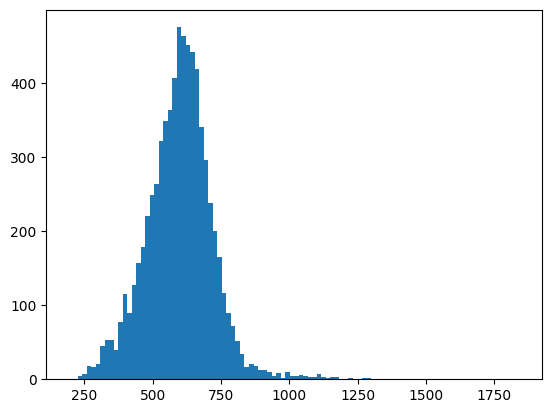

In [28]:
len_list = [len(line[0]) for line in corpus_encoded]

plt.hist(len_list, bins=100)
print("Max length:", max(len_list))
print("Min length:", min(len_list))

In [29]:
def pad_corpus(corpus, max_length, tokenizer):
    pad_token = tokenizer.token_to_idx["<pad>"]
    padded_corpus = []
    for line in tqdm(corpus):
        if line.shape[1] < max_length:
            padding = tf.repeat(tf.constant([[pad_token]]), max_length - line.shape[1], axis=1)
            padded_line = tf.concat([line, padding], axis=1)
        else:
            padded_line = line[:, :max_length]
        padded_corpus.append(padded_line)
    return padded_corpus

In [30]:
corpus_padded = pad_corpus(corpus_encoded, 768, tokenizer)

  0%|          | 0/7199 [00:00<?, ?it/s]

In [31]:
def count_padded_ratio(corpus_padded):
    padded_count = 0
    total_count = 0
    for line in corpus_padded:
        total_count += line.shape[1]
        padded_count += tf.reduce_sum(tf.cast(line == tokenizer.token_to_idx["<pad>"], tf.int32)).numpy()
        
    return padded_count / total_count

In [32]:
count_padded_ratio(corpus_padded)

0.22816482758021947

In [33]:
pkl.dump(tf.concat(corpus_padded, axis=0), open('corpus/corpus_coqa_padded_8k', 'wb'))

## 